In [111]:
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans

In [112]:
df = pd.read_csv('DS Challenge.csv', sep=';', encoding='utf8')

In [113]:
df['cashback'] = df['cashback'].str.replace(',', '.').astype(float)
df['monto'] = df['monto'].str.replace(',', '.').astype(float)
df['dcto'] = df['dcto'].str.replace(',', '.').astype(float)

# https://www.utf8-chartable.de/unicode-utf8-table.pl?start=128&number=128&utf8=string-literal&unicodeinhtml=hex
df['tipo_tc'] = df['tipo_tc'].str.replace('\xc3\xad','í').astype(str) 

df['date'] = df.apply(lambda row: datetime.strptime(str(row['fecha']) + ' ' + str(row['hora']) + ':00:00', '%d/%m/%Y %H:%M:%S').timestamp(), axis=1)
df['date'] = df['date'].astype('int64')

df['genero'] = df['genero'].replace('--', np.NaN)

In [114]:
def split_dispositivo_column(row):
    dispositivo = row['dispositivo'].replace(';', ',').replace('\'','\"')
    model = json.loads(dispositivo).get('model')
    score = json.loads(dispositivo).get('device_score')
    os = json.loads(dispositivo).get('os')
    os = 'unknown_category_1' if os == ',' else ('unknown_category_2' if os == '%%' else os)
    return pd.Series([model, score, os])
    
df[['dispositivo_model', 'dispositivo_puntaje', 'dispositivo_os']] = df.apply(split_dispositivo_column, axis = 1)

In [115]:
df.head()

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje,dispositivo_os
0,0,F,608.345633,21/01/2020,20,{'model': 2020; 'device_score': 3; 'os': 'ANDR...,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,1579654800,2020,3,ANDROID
1,0,F,88.719243,15/01/2020,7,{'model': 2020; 'device_score': 1; 'os': 'ANDR...,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,1579089600,2020,1,ANDROID
2,1,F,790.037653,17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1579276800,2020,1,unknown_category_1
3,1,F,767.005387,5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,1578240000,2020,3,WEB
4,1,F,254.171053,30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,1580396400,2020,3,unknown_category_2


### Completando missing values

Algo que hay que notar en el dataset es que cada usuario (ID_USER) se encuentra ordenado de menor a mayor y cada usuario tiene sus filas juntas (no estan desordenadas)

In [116]:
df[df['ID_USER'] == 7]

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje,dispositivo_os
23,7,NaN,905.115072,22/01/2020,23,{'model': 2020; 'device_score': 4; 'os': 'ANDR...,NaN,Guadalajara,Virtual,72000,57,Aceptada,False,90.511507,16.292071,False,1579752000,2020,4,ANDROID
24,7,NaN,392.693737,16/01/2020,10,{'model': 2020; 'device_score': 1; 'os': '%%'},NaN,Guadalajara,Física,72000,57,Aceptada,False,0.000000,3.926937,False,1579186800,2020,1,unknown_category_2
25,7,NaN,621.604701,19/01/2020,13,{'model': 2020; 'device_score': 2; 'os': '%%'},MPago,Guadalajara,Física,72000,57,Aceptada,False,0.000000,6.216047,False,1579456800,2020,2,unknown_category_2
26,7,NaN,43.721670,4/01/2020,17,{'model': 2020; 'device_score': 1; 'os': 'WEB'},Abarrotes,Guadalajara,Física,72000,57,Aceptada,False,0.000000,0.437217,True,1578175200,2020,1,WEB
27,7,NaN,444.299342,17/01/2020,6,{'model': 2020; 'device_score': 3; 'os': 'WEB'},NaN,Guadalajara,Virtual,72000,57,En proceso,False,0.000000,8.885987,False,1579258800,2020,3,WEB


Notamos como el usuario con id '7' tiene su información de la fila 23 a la fila 27 continuamente.

In [117]:
df[df['ID_USER'] == 1]

,ID_USER,genero,monto,fecha,hora,dispositivo,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_model,dispositivo_puntaje,dispositivo_os
2,1,F,790.037653,17/01/2020,11,"{'model': 2020; 'device_score': 1; 'os': ','}",NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,1579276800,2020,1,unknown_category_1
3,1,F,767.005387,5/01/2020,11,{'model': 2020; 'device_score': 3; 'os': 'WEB'},MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,1578240000,2020,3,WEB
4,1,F,254.171053,30/01/2020,10,{'model': 2020; 'device_score': 3; 'os': '%%'},NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,1580396400,2020,3,unknown_category_2
5,1,F,37.003747,27/01/2020,3,{'model': 2020; 'device_score': 2; 'os': '%%'},NaN,Guadalajara,Física,94000,56,Rechazada,False,0.000000,0.370037,False,1580112000,2020,2,unknown_category_2
6,1,F,334.516017,6/01/2020,2,{'model': 2020; 'device_score': 1; 'os': '%%'},Abarrotes,Guadalajara,Física,94000,56,Aceptada,False,33.451602,3.010644,False,1578294000,2020,1,unknown_category_2
7,1,F,322.264405,11/01/2020,13,{'model': 2020; 'device_score': 4; 'os': '%%'},MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,3.222644,False,1578765600,2020,4,unknown_category_2
8,1,F,911.797804,19/01/2020,3,"{'model': 2020; 'device_score': 3; 'os': ','}",Abarrotes,Guadalajara,Virtual,94000,56,Aceptada,False,91.179780,16.412360,False,1579420800,2020,3,unknown_category_1


#### Recordar:
* Son 3 parámetros los que poseen valores faltantes
  - Ciudad
  - Establecimiento
  - Género
  


In [118]:
groups = df.groupby('ID_USER')

### CIUDAD

Como podemos ver cada usuario tiene sus respectivas transacciones (compras) por lo que podríamos completar los valores faltantes con la siguiente lógica:

Como cada usuario es muy probable que realize su compra en la misma ciudad vamos a agrupar por usuario (id) y vamos a completar los valores faltantes con el valor de ciudad que más se repite. (Es esta mi primera intuición)

In [119]:
# Antes de completar la ciudad veamos cuantos valores faltan
df.ciudad.isnull().sum()

11678

Puede darse el caso que un usuario no tenga ninguna transaccion con alguna ciudad registrada en ese caso vamos a dejar como vació por ahora.

In [120]:
mode_by_group = groups['ciudad'].transform(lambda x: x.mode().get(0, np.NaN))
df['ciudad'] = df['ciudad'].fillna(mode_by_group)

In [121]:
# Despues de completar la lógica anterior
df.ciudad.isnull().sum()

11678

Vemos que ningun valor fue agregado, esto nos dice:
- Cuando un usuario no tiene ciudad registrada, este problema se presenta para todas las transacciones (del usuario en cuestión)

Intentemos con clasicos ffill y bfill

Text(0, 0.5, 'Cantidad')

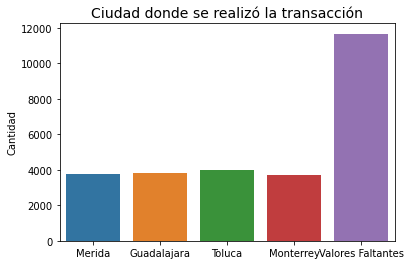

In [122]:
# ORIGINAl
sns.countplot(x = 'ciudad', data=df.fillna('Valores Faltantes'))
plt.title('Ciudad donde se realizó la transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Queremos que estas proporciones se mantengan (Toluca más que Guadalajara luego Mérida muy similar a Monterrey)

Text(0, 0.5, 'Cantidad')

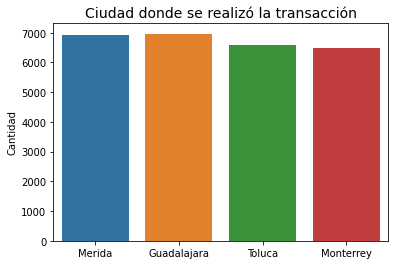

In [123]:
sns.countplot(x = 'ciudad', data=df.fillna(method='ffill'))
plt.title('Ciudad donde se realizó la transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

No se mantuvo la proporcion deseada

Text(0, 0.5, 'Cantidad')

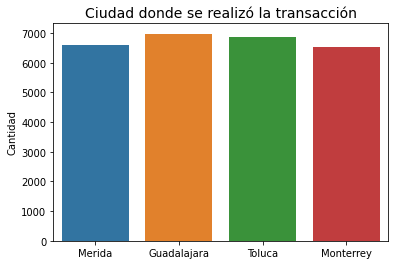

In [124]:
sns.countplot(x = 'ciudad', data=df.fillna(method='bfill'))
plt.title('Ciudad donde se realizó la transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Se mantuvo la proporción deseada (al menos es muy similar) por lo que obtaremos por **bfill**

In [125]:
df['ciudad'] = df['ciudad'].fillna(method='bfill')

In [126]:
df.ciudad.isnull().sum()

0

Completamos odos los valores faltantes para ciudad

### Establecimiento

Como cada usuario es probable que realize su compra en el mismo establecimiento, vamos a agrupar por usuario (id) y vamos a completar los valores faltantes con el valor de establecimiento que más se repite. (Es esta mi primera intuición)

In [127]:
# Antes de completar el establecimiento veamos cuantos valores faltan
df.establecimiento.isnull().sum()

10119

Puede darse el caso que un usuario no tenga ninguna transaccion con algun establecimiento registrado en ese caso vamos a dejar como vació por ahora.

In [128]:
## Salvamos la columna establecimiento 
df_temp_establecimiento = df['establecimiento'].copy()

In [129]:
mode_by_group = groups['establecimiento'].transform(lambda x: x.mode().get(0, np.NaN))
df['establecimiento'] = df['establecimiento'].fillna(mode_by_group)

In [130]:
# Despues de completar la lógica anterior
df.establecimiento.isnull().sum()

498

Observamos que 498 valores no tienen ningun valor porque cuando se agrupo por usuario y se busco su establecimiento más común, este no tenía absolutamente ningun establecimiento registrado.
Estos valores vamos a completarlos con bfill o ffill **solo para estos 498 valores** que no pudieron ser completados con la lógica anterior

Text(0, 0.5, 'Cantidad')

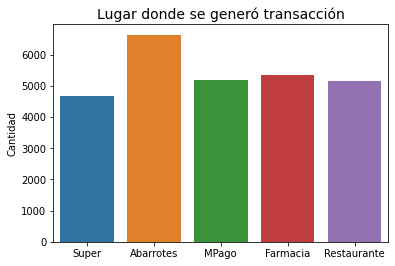

In [131]:
sns.countplot(x = 'establecimiento', data=df.fillna(method='bfill'))
plt.title('Lugar donde se generó transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad')

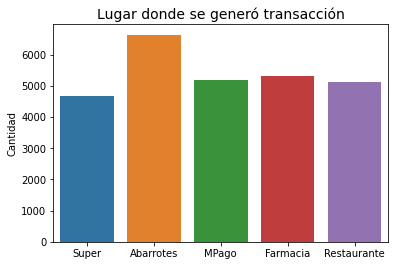

In [132]:
sns.countplot(x = 'establecimiento', data=df.fillna(method='ffill'))
plt.title('Lugar donde se generó transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Notamos que en ambos casos el balor de abarrotes se repunto con respecto a sus demás categorias.

veamos alguna información en internet:

![alt text](mexico_2017.jpg "Mexico 2017")
![alt text](mexico_2020.jpg "Mexico 2020")

Esta información muestra la segmentacion de las compras en linea antes (2017) y despues (2020) del covid y como se mencionaba antes, estos datasets reales muestran categorias totalmente **desequilibradas** a comparacion del dataset **que tenemos** el cual mantiene sus categorias de establecimiento **muy equilibradas** (obviando los valores faltantes). Por lo que:

- Reemplazar el establecimiento más frecuente por usuario no es una buena idea, nos deja la data desequilibrada (por fines del challenge lo tenemos equilibrado y continuemos así)

- Realizar un simple bfill, igual que para la columna ciudad y veamos.


In [133]:
### Regresemos a los valores originales
df['establecimiento'] = df_temp_establecimiento

In [134]:
# Obtenemos los mismos valores faltantes del dataset original porque recuperamos estos valores
df.establecimiento.isnull().sum()

10119

Text(0, 0.5, 'Cantidad')

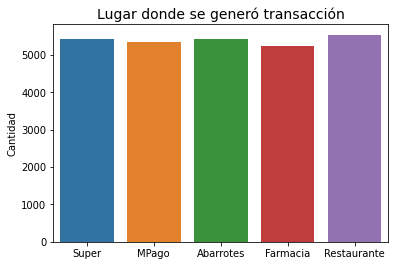

In [135]:
sns.countplot(x = 'establecimiento', data=df.fillna(method='bfill'))
plt.title('Lugar donde se generó transacción', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Nuestra segúnda intuición es correcta y el bfill (**para todos los valores faltantes**) nos deja un dataset muucho más equilibrado que es como tenemos nuestra dataset del challenge

In [136]:
df['establecimiento'] = df['establecimiento'].fillna(method='bfill')
df.establecimiento.isnull().sum()

0

Completamos todos los valores faltantes, no dejamos ninguno.

Observacion:
  - Se consideró que un usuario podia comprar en el mismo establecimiento (cliente fiel a su establecimiento) por lo que la primera intuición fue: llenar los valores faltantes de cada usuario con la informacion del establecimiento mas frecuente en sus transacciones
  - La consieración anterior fue errada por que nos dejo el dataset desequilibrado y también no se considero el tiempo.
  - En un mes una persona realiza compras para su hogar pero no todas las hara en el mismo lugar, es decir, según lo que observamos en el dataset y como bien se sabe en la vida común de una persona necesitamos comprar ciertos elementos para nuestra casa y lo mas seguro es que las haremos en distintos establecimientos porque no solo vivimos de una sola categoría de productos, es por esta razon que cuando pusimos que los valores faltantes sean del establecimiento que más frecuenta nos dejó desequilibrado los datos.


### Género

In [137]:
# Antes de completar el género veamos cuantos valores faltan
df.genero.isnull().sum()

2730

In [138]:
## Salvamos la columna género 
df_temp_genero = df['genero'].copy()

In [139]:
mode_by_group = groups['genero'].transform(lambda x: x.mode().get(0, np.NaN))
df['genero'] = df['genero'].fillna(mode_by_group)

In [140]:
## Despues de completar el género
df.genero.isnull().sum()

2730

Igual que en el caso de ciudad observamos que cuando agrupos por usuario, ninguna de sus transacciones muestra el género.
Intentemos con bfill o fill

Text(0, 0.5, 'Cantidad')

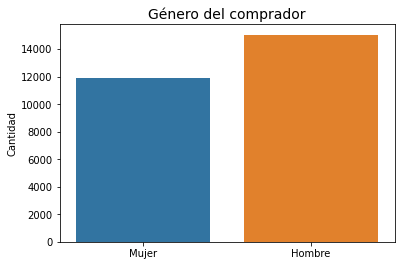

In [141]:
sns.countplot(x = 'genero', data=df.fillna(method='bfill'))

plt.xticks(np.arange(2), ("Mujer","Hombre"))
plt.title('Género del comprador', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Text(0, 0.5, 'Cantidad')

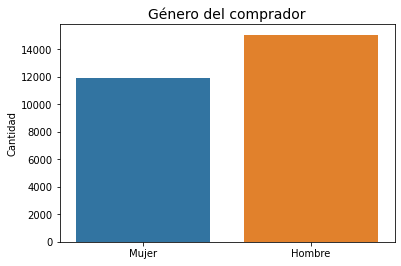

In [142]:
sns.countplot(x = 'genero', data=df.fillna(method='ffill'))

plt.xticks(np.arange(2), ("Mujer", "Hombre"))
plt.title('Género del comprador', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Los dós métodos nos dejan la misma proporción del dataset original por lo que se peude tomar cualquiera de ellos: usaremos bfill para seguir el mismo patron que las columnas establecimiento y ciudad.

In [143]:
df['genero'] = df['genero'].fillna(method='bfill')

In [144]:
## Despues de completar el género
df.genero.isnull().sum()

0

Completamos asi las 3 columnas con valore faltantes

### Manejando la clasificacion de clientes

En este caso se pidio **categorizar los clientes** por lo que en base a la empresa a la cual estamos realizando el análisis se podrá tomar enfoques distintos, por ejemplo a una empresa de marketing le interesaría saber el horario a la cual compra la mayor cantida de gente, una empresa de transporte le importaria saber en que establecimiento se hizo más compras y a una empresa de pasarela de pagos ¿ Quien es su cliente que le genera mas revenue ?, el challenge indica proponer una de estas categorias por lo que obtaremos arbitrariamente con el último caso

In [145]:
# Sacando algunas columnas para categorizar usuarios que realizan transacciones con mayor revenue:
df_for_revenue = df.copy()

In [146]:
# No necesitamos estas columnas ya que en caso de fecha a hora fueron pasados a date, en caso de dispositivo se paso a 
# 3 categorias de la cual dispositivo_model solo presenta una categoria para todos los datos
df_for_revenue = df_for_revenue.drop(['fecha', 'hora', 'dispositivo', 'dispositivo_model'], axis=1)

In [147]:
# is prime y fraude son booleanos por lo que pasamos a 0 y 1
df_for_revenue['is_prime'] = df_for_revenue['is_prime'].astype(int)
df_for_revenue['fraude'] = df_for_revenue['fraude'].astype(int)

In [148]:
df_for_revenue.head()

,ID_USER,genero,monto,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_puntaje,dispositivo_os
0,0,F,608.345633,Super,Merida,Física,71000,51,Aceptada,0,60.834563,5.475111,0,1579654800,3,ANDROID
1,0,F,88.719243,MPago,Merida,Virtual,71000,51,Aceptada,0,0.000000,1.774385,0,1579089600,1,ANDROID
2,1,F,790.037653,MPago,Guadalajara,Virtual,94000,56,En proceso,0,0.000000,15.800753,0,1579276800,1,unknown_category_1
3,1,F,767.005387,MPago,Guadalajara,Física,94000,56,Aceptada,0,0.000000,7.670054,0,1578240000,3,WEB
4,1,F,254.171053,Abarrotes,Guadalajara,Física,94000,56,Aceptada,0,0.000000,2.541711,0,1580396400,3,unknown_category_2


#### Escalamos los datos

In [149]:
std_scaler = StandardScaler() # no outliers para monto y date
rob_scaler = RobustScaler() # robusto cuando hay outliers : como dcto y cashback (como vimos en EDA.ipynb)


df_for_revenue['monto'] = std_scaler.fit_transform(df_for_revenue['monto'].values.reshape(-1,1))
df_for_revenue['date'] = std_scaler.fit_transform(df_for_revenue['date'].values.reshape(-1,1))

df_for_revenue['dcto'] = rob_scaler.fit_transform(df_for_revenue['dcto'].values.reshape(-1,1))
df_for_revenue['cashback'] = rob_scaler.fit_transform(df_for_revenue['cashback'].values.reshape(-1,1))

In [150]:
df_for_revenue.head()

,ID_USER,genero,monto,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,date,dispositivo_puntaje,dispositivo_os
0,0,F,0.377721,Super,Merida,Física,71000,51,Aceptada,0,3.24093,-0.028154,0,0.630889,3,ANDROID
1,0,F,-1.418404,MPago,Merida,Virtual,71000,51,Aceptada,0,0.00000,-0.672895,0,-0.149276,1,ANDROID
2,1,F,1.005752,MPago,Guadalajara,Virtual,94000,56,En proceso,0,0.00000,1.770781,0,0.109123,1,unknown_category_1
3,1,F,0.926139,MPago,Guadalajara,Física,94000,56,Aceptada,0,0.00000,0.354249,0,-1.322007,3,WEB
4,1,F,-0.846509,Abarrotes,Guadalajara,Física,94000,56,Aceptada,0,0.00000,-0.539211,0,1.654545,3,unknown_category_2


#### Primer paso

Nos quedamos con las variables que no son categoricas y de enterés, para esto agrupamos por usuario

In [151]:
agg_for_revenue = { 
            'monto': lambda x: x.mean(),
            'is_prime': lambda x: x.mean(),
            'dcto': lambda x: x.mean(),
            'cashback': lambda x: x.mean(),
            'fraude': lambda x: x.mean(),
            'date': lambda x: x.mean(),
        }


In [152]:
df_for_revenue_root = df_for_revenue.groupby('ID_USER').agg(agg_for_revenue)

#### Segundo paso
Agrupamos por usuario, cruzamos con las categorias y nos quedamos con distintas funciones del monto (suma, maximo, minimo, ...)

In [153]:
def makeForCategory(df, c, aggfunc=sum):
    try:
        ct = pd.crosstab(df['ID_USER'], df[c], values=df.monto, aggfunc=aggfunc)
    except:
        ct = pd.crosstab(df['ID_USER'], df[c], values=df.monto, aggfunc=aggfunc)
    ct.columns = [f"{c}_{aggfunc.__name__}_{v}" for v in ct.columns]
    return ct

In [154]:
df_for_revenue_uncategory = []

aggfuncs = [len, sum, min, max]
for c in df_for_revenue.drop(["ID_USER", "monto", "is_prime", "dcto", "cashback", 'fraude', "date"], axis=1):
    print("Haciendo: ", c)
    df_for_revenue_uncategory.extend([makeForCategory(df_for_revenue, c, aggfunc) for aggfunc in aggfuncs])

Haciendo:  genero
Haciendo:  establecimiento
Haciendo:  ciudad
Haciendo:  tipo_tc
Haciendo:  linea_tc
Haciendo:  interes_tc
Haciendo:  status_txn
Haciendo:  dispositivo_puntaje
Haciendo:  dispositivo_os


De lista pasamos a df

In [155]:
df_for_revenue_uncategory = pd.concat(df_for_revenue_uncategory, axis=1)

Unimos ahora los que fueron tratados con categoria con los iniciales que habiamos extraidos, todos agrupados por usuario

In [156]:
df_for_revenue = pd.concat([df_for_revenue_root, df_for_revenue_uncategory], axis = 1)
df_for_revenue.head()

,monto,is_prime,dcto,cashback,fraude,date,genero_len_F,genero_len_M,genero_sum_F,genero_sum_M,...,dispositivo_os_sum_unknown_category_1,dispositivo_os_sum_unknown_category_2,dispositivo_os_min_ANDROID,dispositivo_os_min_WEB,dispositivo_os_min_unknown_category_1,dispositivo_os_min_unknown_category_2,dispositivo_os_max_ANDROID,dispositivo_os_max_WEB,dispositivo_os_max_unknown_category_1,dispositivo_os_max_unknown_category_2
ID_USER,,,,,,,,,,,,,,,,,,,,,
0,-0.520342,0.0,1.620465,-0.350524,0.0,0.240807,2.0,NaN,-1.040684,NaN,...,NaN,NaN,-1.418404,NaN,NaN,NaN,0.377721,NaN,NaN,NaN
1,-0.037869,0.0,0.948525,0.238214,0.0,0.023937,7.0,NaN,-0.265086,NaN,...,2.432376,-3.623601,NaN,0.926139,1.005752,-1.597162,NaN,0.926139,1.426624,-0.568791
2,-0.347431,0.0,2.092596,-0.269096,0.0,0.177982,7.0,NaN,-2.432018,NaN,...,NaN,-0.214719,-1.515107,-1.171688,NaN,-0.214719,0.266756,0.345466,NaN,-0.214719
3,-0.898996,0.0,0.000000,-0.565667,0.0,1.145202,2.0,NaN,-1.797993,NaN,...,NaN,NaN,-1.508660,NaN,NaN,NaN,-0.289333,NaN,NaN,NaN
4,-0.766989,0.0,2.953288,-0.595711,0.0,1.276885,NaN,1.0,NaN,-0.766989,...,NaN,NaN,NaN,-0.766989,NaN,NaN,NaN,-0.766989,NaN,NaN


In [161]:
# nan reemplazando por 0
df_for_revenue.fillna(0, inplace=True)
df_for_revenue.head()

,monto,is_prime,dcto,cashback,fraude,date,genero_len_F,genero_len_M,genero_sum_F,genero_sum_M,...,dispositivo_os_sum_unknown_category_1,dispositivo_os_sum_unknown_category_2,dispositivo_os_min_ANDROID,dispositivo_os_min_WEB,dispositivo_os_min_unknown_category_1,dispositivo_os_min_unknown_category_2,dispositivo_os_max_ANDROID,dispositivo_os_max_WEB,dispositivo_os_max_unknown_category_1,dispositivo_os_max_unknown_category_2
ID_USER,,,,,,,,,,,,,,,,,,,,,
0,-0.520342,0.0,1.620465,-0.350524,0.0,0.240807,2.0,0.0,-1.040684,0.000000,...,0.000000,0.000000,-1.418404,0.000000,0.000000,0.000000,0.377721,0.000000,0.000000,0.000000
1,-0.037869,0.0,0.948525,0.238214,0.0,0.023937,7.0,0.0,-0.265086,0.000000,...,2.432376,-3.623601,0.000000,0.926139,1.005752,-1.597162,0.000000,0.926139,1.426624,-0.568791
2,-0.347431,0.0,2.092596,-0.269096,0.0,0.177982,7.0,0.0,-2.432018,0.000000,...,0.000000,-0.214719,-1.515107,-1.171688,0.000000,-0.214719,0.266756,0.345466,0.000000,-0.214719
3,-0.898996,0.0,0.000000,-0.565667,0.0,1.145202,2.0,0.0,-1.797993,0.000000,...,0.000000,0.000000,-1.508660,0.000000,0.000000,0.000000,-0.289333,0.000000,0.000000,0.000000
4,-0.766989,0.0,2.953288,-0.595711,0.0,1.276885,0.0,1.0,0.000000,-0.766989,...,0.000000,0.000000,0.000000,-0.766989,0.000000,0.000000,0.000000,-0.766989,0.000000,0.000000


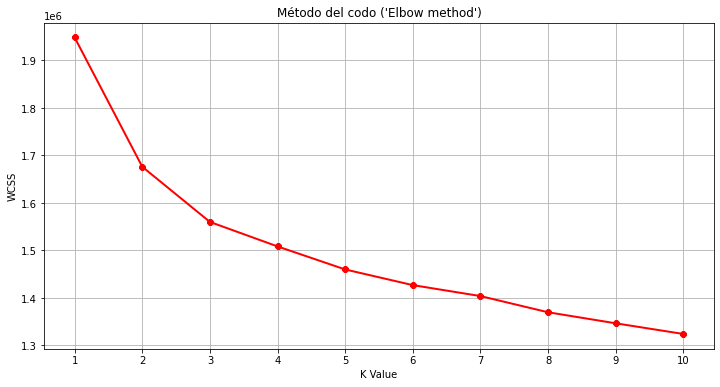

In [165]:
# Within Cluster Sum Of Squares (wcss)

wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(df_for_revenue)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.title('Método del codo (\'Elbow method\')')
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

Como vemos por el método del codo para k = 5, existen 5 grupos los cuales se segmentaron dando mayor enfasis al monto que generan 

In [181]:
km = KMeans(n_clusters=5)
clusters = km.fit_predict(df_for_revenue)
df_for_revenue["label"] = clusters

Recordar que aqui son solo 4000 clientes, vemos que existen más de la clase 0

In [195]:
df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==0].index[0]].mean()

C:\Users\Nilton\AppData\Local\Temp/ipykernel_17224/1637304608.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==0].index[0]].mean()


ID_USER                0.000000e+00
monto                  3.485324e+02
hora                   1.350000e+01
linea_tc               7.100000e+04
interes_tc             5.100000e+01
is_prime               0.000000e+00
dcto                   3.041728e+01
cashback               3.624748e+00
fraude                 0.000000e+00
date                   1.579372e+09
dispositivo_model      2.020000e+03
dispositivo_puntaje    2.000000e+00
dtype: float64

In [196]:
df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==1].index[0]].mean()

C:\Users\Nilton\AppData\Local\Temp/ipykernel_17224/1230335644.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==1].index[0]].mean()


ID_USER                8.000000e+00
monto                  4.250972e+02
hora                   1.085714e+01
linea_tc               7.600000e+04
interes_tc             5.800000e+01
is_prime               0.000000e+00
dcto                   1.506983e+01
cashback               4.864977e+00
fraude                 0.000000e+00
date                   1.579400e+09
dispositivo_model      2.020000e+03
dispositivo_puntaje    2.428571e+00
dtype: float64

In [197]:
df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==2].index[0]].mean()

C:\Users\Nilton\AppData\Local\Temp/ipykernel_17224/673736319.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==2].index[0]].mean()


ID_USER                1.000000e+00
monto                  4.881137e+02
hora                   7.571429e+00
linea_tc               9.400000e+04
interes_tc             5.600000e+01
is_prime               0.000000e+00
dcto                   1.780448e+01
cashback               7.004029e+00
fraude                 0.000000e+00
date                   1.579215e+09
dispositivo_model      2.020000e+03
dispositivo_puntaje    2.428571e+00
dtype: float64

In [198]:
df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==3].index[0]].mean()

C:\Users\Nilton\AppData\Local\Temp/ipykernel_17224/2564812972.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==3].index[0]].mean()


ID_USER                1.900000e+01
monto                  5.822026e+02
hora                   9.294118e+00
linea_tc               2.800000e+04
interes_tc             4.200000e+01
is_prime               0.000000e+00
dcto                   1.824650e+01
cashback               7.075790e+00
fraude                 5.882353e-02
date                   1.579530e+09
dispositivo_model      2.020000e+03
dispositivo_puntaje    2.588235e+00
dtype: float64

In [199]:
df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==4].index[0]].mean()

C:\Users\Nilton\AppData\Local\Temp/ipykernel_17224/2554676294.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df[df['ID_USER'] == df_for_revenue[df_for_revenue['label']==4].index[0]].mean()


ID_USER                3.600000e+01
monto                  4.698296e+02
hora                   1.136842e+01
linea_tc               9.400000e+04
interes_tc             4.200000e+01
is_prime               0.000000e+00
dcto                   1.799745e+01
cashback               4.793250e+00
fraude                 0.000000e+00
date                   1.579351e+09
dispositivo_model      2.020000e+03
dispositivo_puntaje    2.421053e+00
dtype: float64

##### Se observa que:

* Clase 0: media monto 345 ~ Menos dinero
* Clase 1: media monto 420
* Clase 2: media monto 485
* Clase 3: media monto 575 - Más dinero !!!
* Clase 4: media monto 465

Como se ve no estan por orden pero ahora mostramos una gráfica notando donde estan cada uno

Text(0, 0.5, 'Cantidad')

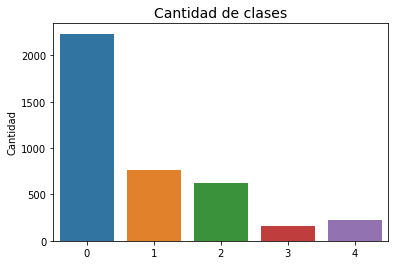

In [184]:
sns.countplot(x = 'label', data=df_for_revenue)
plt.title('Cantidad de clases', fontsize=14)
plt.xlabel('')
plt.ylabel('Cantidad')

Si bien es cierto una situación a considerar es que primero se agrupo por cliente es decir si bien es cierto el monto estaba equilibrado pero era por transaccion no por cliente, ahora vemos que existe clientes más de la clase 0 que son los que poco transaccionan, y muy pocos clientes de la clase 3 que trae más ganancias (mas monto, menos devolucion y descuentos y también menos fraude)

Si todo esta data le pertenece a una pasarela de pagos (por que toda la data es transaccional) se diria que no tenemos muchos clientes que generén mucho dinero.